# Demo 3 - Classificação de sentimento em reviews de filmes com base do IMDB via RNNs (Recurrent Neural Networks)

Neste notebook iremos treinar uma Rede Neural Recorrent (RNN) para classificação de sentimento usando Keras (com Tensorflow como backend).

In [19]:
#!pip install --upgrade keras

In [20]:
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.datasets import imdb

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using Keras version: 2.4.3 backend: tensorflow


## Base de dados do IMDB (https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset) 

Em seguida, carregaremos o conjunto de dados do IMDB. Na primeira vez, talvez tenhamos que baixar os dados, o que pode demorar um pouco. O conjunto de dados contém 50000 avaliações de filmes do Internet Movie Database, dividido em 25.000 avaliações para treinamento e 25.000 avaliações para testes. Metade dos comentários são positivos (1) e metade são negativos (0).

O conjunto de dados já foi pré-processado e cada palavra foi substituída por um índice inteiro.

As revisões são, portanto, representadas como sequências de comprimento variável de inteiros, como consta:

(Os índices de palavras começam em "3", como "1" é usado para marcar o início de uma revisão e "2" representa todas as palavras fora do vocabulário existente. "0" será usado posteriormente para preencher comentários mais curtos em um tamanho fixo .)


* Mais informações e créditos originais:

Maas, Andrew L. and Daly, Raymond E. and Pham, Peter T. and Huang, Dan and Ng, Andrew Y. and Potts, Christopher, "Learning Word Vectors for Sentiment Analysis", em Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies, June, 2011. Portland, Oregon, USA. Association for Computational Linguistics. Pages 142 a150. Disponível em: http://www.aclweb.org/anthology/P11-1015

In [21]:
# número de palavras mais frequentes para se utilizar:

nb_words = 10000

# cortar textos a partir do seguinte número de palavras (maxlenght):

maxlen = 80

print('Carregando...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

print('Sequencias (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Carregando...
x_train: (25000,)
x_test: (25000,)

Sequencias (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


Mostrando nosso primeiro review no set de treinamento:

In [22]:
print("Primeiro review no set de treinamento:\n \n", x_train[0], "comprimento:", len(x_train[0]), "classe:", y_train[0])

Primeiro review no set de treinamento:
 
 [  15  256    4    2    7 3766    5  723   36   71   43  530  476   26
  400  317   46    7    4    2 1029   13  104   88    4  381   15  297
   98   32 2071   56   26  141    6  194 7486   18    4  226   22   21
  134  476   26  480    5  144   30 5535   18   51   36   28  224   92
   25  104    4  226   65   16   38 1334   88   12   16  283    5   16
 4472  113  103   32   15   16 5345   19  178   32] comprimento: 80 classe: 1


## Inicialização

Vamos criar um modelo RNN que tenha uma (ou, opcionalmente, duas) camadas LSTM e de Dropout. 

A primeira camada na rede é uma camada de Embedding que converte índices inteiros em vetores densos de comprimento ´embedding_dims`. A camada de saída contém um único neurônio e uma não-linearidade do tipo sigmóide para coincidir com a groundtruth binária (`y_train`).

Finalmente, nós `compilamos ()` o modelo, usando entropia cruzada binária como a função de perda e [* RMSprop *] (https://keras.io/optimizers/#rmsprop) como otimizador.

In [23]:
# Parâmetros do modelo:

embedding_dims = 50
lstm_units = 32

print('Construindo nosso modelo...')
model = Sequential()

model.add(Embedding(nb_words,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

#se estiver executando sem GPU:

model.add(LSTM(lstm_units))

# se estiver executando numa GPU:

#model.add(CuDNNLSTM(lstm_units, return_sequences=True))

# Para empilhar várias camadas RNN, todas as camadas RNN, exceto a última
# precisam ter "return_sequences = True". Um exemplo de uso de duas camadas RNN:

#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(LSTM(lstm_units))

model.add(Dense(1, activation='sigmoid'))

# Tentem utilizar outros otimizadores e configurações

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Construindo nosso modelo...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 50)            500000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 510,657
Trainable params: 510,657
Non-trainable params: 0
_________________________________________________________________
None


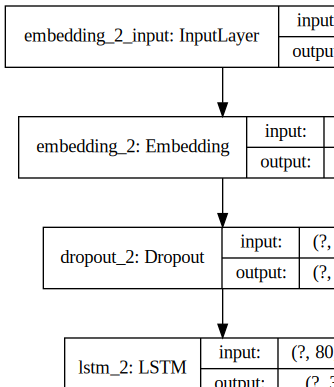

In [24]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Aprendizagem (Treino)

Agora estamos prontos para treinar nosso modelo. 

Lembrem-se que uma * época * significa uma passagem por todos os dados de treinamento. Note também que estamos usando uma fração dos dados de treinamento como nosso conjunto de validação.

Note que as camadas LSTMs são lentas para se treinar.

In [25]:
%%time
epochs = 5
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)


Epoch 1/5
157/157 [==============================] - 2s 13ms/step - loss: 0.5004 - accuracy: 0.7566 - val_loss: 0.3983 - val_accuracy: 0.8230
Epoch 2/5
157/157 [==============================] - 2s 11ms/step - loss: 0.3239 - accuracy: 0.8644 - val_loss: 0.4830 - val_accuracy: 0.8140
Epoch 3/5
157/157 [==============================] - 2s 11ms/step - loss: 0.2717 - accuracy: 0.8890 - val_loss: 0.3625 - val_accuracy: 0.8390
Epoch 4/5
157/157 [==============================] - 2s 11ms/step - loss: 0.2441 - accuracy: 0.9051 - val_loss: 0.3856 - val_accuracy: 0.8424
Epoch 5/5
157/157 [==============================] - 2s 11ms/step - loss: 0.2217 - accuracy: 0.9133 - val_loss: 0.3657 - val_accuracy: 0.8334
CPU times: user 11.4 s, sys: 932 ms, total: 12.3 s
Wall time: 10.2 s


Vamos plotar os dados para ver como o treinamento progrediu. 

Obs: Se observarmos um grande gap entre os valores de precisões de treinamento e validação isso normalmente sugere overfitting.

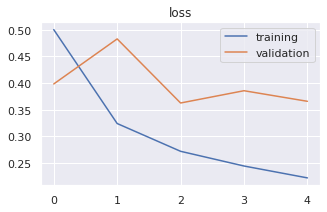

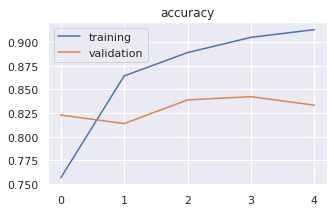

In [26]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'], label='training')
plt.plot(history.epoch,history.history['val_accuracy'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

## Insights

Para melhor verificarmos a qualidade do modelo calculamos então nossa acurácia para os dados de teste:

In [27]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

782/782 - 2s - loss: 0.3768 - accuracy: 0.8336
accuracy: 83.36%


---
*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-imdb-rnn.ipynb).*